In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_recall_curve, roc_curve, auc, f1_score
)

from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from scipy.stats import norm

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.4)
rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

LABELS = ["Normal", "Fraud"]


In [35]:
df = pd.read_csv("/content/creditcard.csv")
df.shape


(284807, 31)

In [36]:
df.isnull().values.any()


np.False_

/tmp/ipython-input-568078512.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort=True)


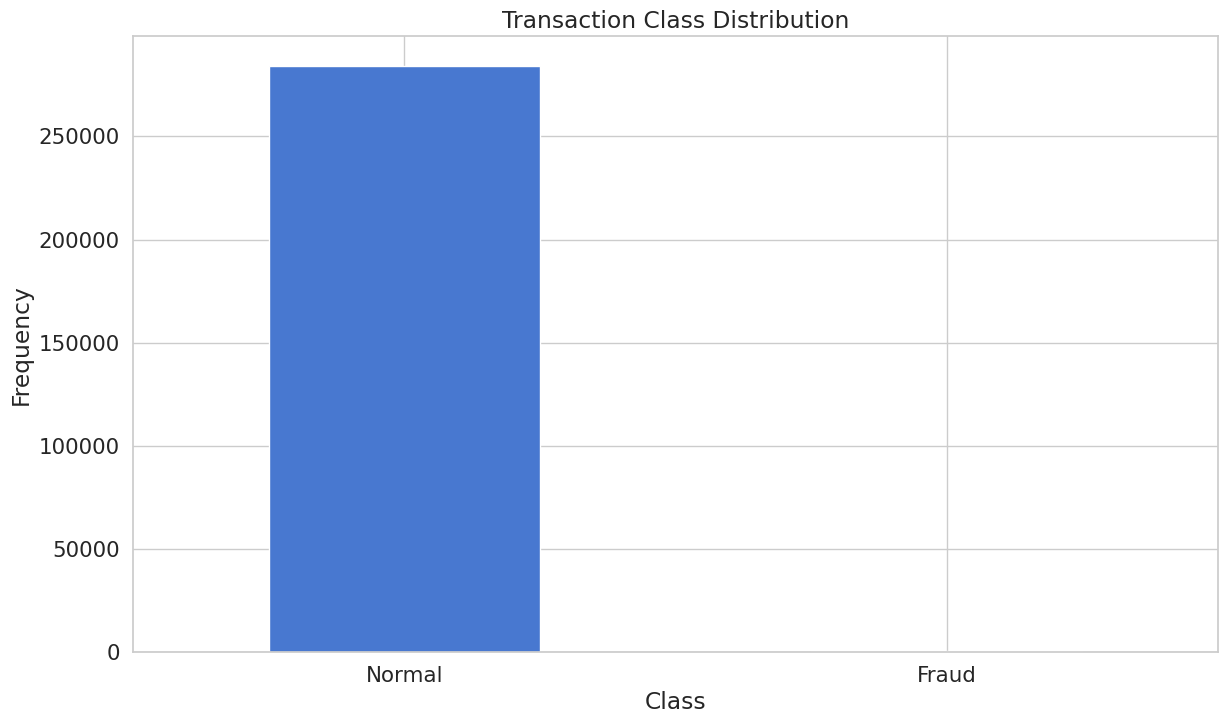

In [37]:
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes.plot(kind='bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()


In [38]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

frauds.Amount.describe(), normal.Amount.describe()


(count     492.000000
 mean      122.211321
 std       256.683288
 min         0.000000
 25%         1.000000
 50%         9.250000
 75%       105.890000
 max      2125.870000
 Name: Amount, dtype: float64,
 count    284315.000000
 mean         88.291022
 std         250.105092
 min           0.000000
 25%           5.650000
 50%          22.000000
 75%          77.050000
 max       25691.160000
 Name: Amount, dtype: float64)

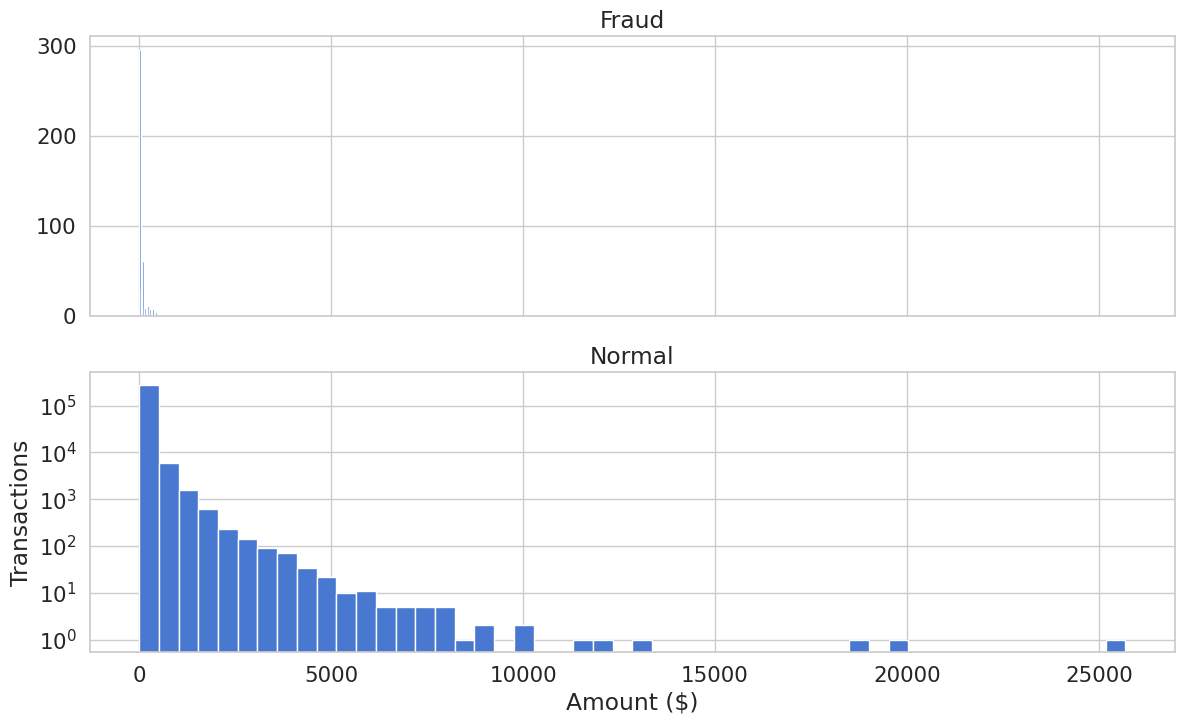

In [39]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
bins = 50

ax1.hist(frauds.Amount, bins=bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins=bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Transactions')
plt.yscale('log')
plt.show()


In [40]:
data = df.drop(['Time'], axis=1)

scaler = RobustScaler()
data['Amount'] = scaler.fit_transform(
    data['Amount'].values.reshape(-1, 1)
)


In [41]:
X_train, X_test = train_test_split(
    data, test_size=0.2, random_state=RANDOM_SEED
)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

X_train.shape, X_test.shape


((227451, 29), (56962, 29))

In [42]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoder = Dense(64)(input_layer)
encoder = BatchNormalization()(encoder)
encoder = tf.keras.layers.LeakyReLU()(encoder)
encoder = Dropout(0.2)(encoder)

encoder = Dense(32)(encoder)
encoder = BatchNormalization()(encoder)
encoder = tf.keras.layers.LeakyReLU()(encoder)

encoder = Dense(16)(encoder)
encoder = BatchNormalization()(encoder)
encoder = tf.keras.layers.LeakyReLU()(encoder)

latent = Dense(8, activation='relu', name="latent_space")(encoder)

decoder = Dense(16, activation='relu')(latent)
decoder = Dense(32, activation='relu')(decoder)
decoder = Dense(64, activation='relu')(decoder)

output_layer = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=output_layer)


In [43]:
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.LogCosh()
)

autoencoder.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,797 (38.27 KB)

 Trainable params: 9,573 (37.39 KB)

 Non-trainable params: 224 (896.00 B)

In [44]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint("best_autoencoder.h5", save_best_only=True)
]

X_val = X_test[y_test.values == 0]

history = autoencoder.fit(
    X_train, X_train,
    epochs=200,
    batch_size=256,
    validation_data=(X_val, X_val),
    shuffle=True,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/200
880/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2234

889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.2229 - val_loss: 0.1215 - learning_rate: 0.0010
Epoch 2/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1266

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1266 - val_loss: 0.0963 - learning_rate: 0.0010
Epoch 3/200
886/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1082

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1081 - val_loss: 0.0864 - learning_rate: 0.0010
Epoch 4/200
886/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1001

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1001 - val_loss: 0.0815 - learning_rate: 0.0010
Epoch 5/200
888/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0953

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0953 - val_loss: 0.0790 - learning_rate: 0.0010
Epoch 6/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0923

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0923 - val_loss: 0.0753 - learning_rate: 0.0010
Epoch 7/200
888/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0896

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0896 - val_loss: 0.0737 - learning_rate: 0.0010
Epoch 8/200
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0873

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0873 - val_loss: 0.0721 - learning_rate: 0.0010
Epoch 9/200
878/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0854

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0854 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 10/200
880/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0837

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0837 - val_loss: 0.0693 - learning_rate: 0.0010
Epoch 11/200
888/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0823

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0823 - val_loss: 0.0679 - learning_rate: 0.0010
Epoch 12/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0810

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0810 - val_loss: 0.0669 - learning_rate: 0.0010
Epoch 13/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0800

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0800 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 14/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0787 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 15/200
888/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0777

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0777 - val_loss: 0.0638 - learning_rate: 0.0010
Epoch 16/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0767 - val_loss: 0.0641 - learning_rate: 0.0010
Epoch 17/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0760

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0760 - val_loss: 0.0631 - learning_rate: 0.0010
Epoch 18/200
881/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0751

889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0751 - val_loss: 0.0615 - learning_rate: 0.0010
Epoch 19/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0743 - val_loss: 0.0616 - learning_rate: 0.0010
Epoch 20/200
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0735

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0735 - val_loss: 0.0608 - learning_rate: 0.0010
Epoch 21/200
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0730

889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0730 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 22/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 0.0726 - val_loss: 0.0601 - learning_rate: 0.0010
Epoch 23/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0719 - val_loss: 0.0602 - learning_rate: 0.0010
Epoch 24/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0717 - val_loss: 0.0604 - learning_rate: 0.0010
Epoch 25/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0712

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0712 - val_loss: 0.0597 - learning_rate: 0.0010
Epoch 26/200
882/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0707

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0707 - val_loss: 0.0586 - learning_rate: 0.0010
Epoch 27/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0702

889/889 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0702 - val_loss: 0.0581 - learning_rate: 0.0010
Epoch 28/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0699 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 29/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0697

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0697 - val_loss: 0.0569 - learning_rate: 0.0010
Epoch 30/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0693 - val_loss: 0.0574 - learning_rate: 0.0010
Epoch 31/200
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0690

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0690 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 32/200
886/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0687

889/889 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0687 - val_loss: 0.0564 - learning_rate: 0.0010
Epoch 33/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0685

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0685 - val_loss: 0.0561 - learning_rate: 0.0010
Epoch 34/200
888/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0682

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0682 - val_loss: 0.0560 - learning_rate: 0.0010
Epoch 35/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0679

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0680 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 36/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0678

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0678 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 37/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0675

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0675 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 38/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0672 - val_loss: 0.0548 - learning_rate: 0.0010
Epoch 39/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0670 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 40/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0667 - val_loss: 0.0553 - learning_rate: 0.0010
Epoch 41/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0663 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 42/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0662 - val_loss: 0.0543 - learning_rate: 0.0010
Epoch 43/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0645

889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.0645 - val_loss: 0.0522 - learning_rate: 5.0000e-04
Epoch 44/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0643

889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0643 - val_loss: 0.0520 - learning_rate: 5.0000e-04
Epoch 45/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0641

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0641 - val_loss: 0.0518 - learning_rate: 5.0000e-04
Epoch 46/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0640

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0640 - val_loss: 0.0516 - learning_rate: 5.0000e-04
Epoch 47/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0637 - val_loss: 0.0519 - learning_rate: 5.0000e-04
Epoch 48/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0635 - val_loss: 0.0519 - learning_rate: 5.0000e-04
Epoch 49/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0632

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0632 - val_loss: 0.0511 - learning_rate: 5.0000e-04
Epoch 50/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0630

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0630 - val_loss: 0.0500 - learning_rate: 5.0000e-04
Epoch 51/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0628 - val_loss: 0.0507 - learning_rate: 5.0000e-04
Epoch 52/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0624 - val_loss: 0.0501 - learning_rate: 5.0000e-04
Epoch 53/200
884/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0621

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0621 - val_loss: 0.0498 - learning_rate: 5.0000e-04
Epoch 54/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0618 - val_loss: 0.0503 - learning_rate: 5.0000e-04
Epoch 55/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0616 - val_loss: 0.0501 - learning_rate: 5.0000e-04
Epoch 56/200
882/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0613

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0613 - val_loss: 0.0498 - learning_rate: 5.0000e-04
Epoch 57/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0612

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0612 - val_loss: 0.0491 - learning_rate: 5.0000e-04
Epoch 58/200
880/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0610

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0610 - val_loss: 0.0487 - learning_rate: 5.0000e-04
Epoch 59/200
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0607

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0607 - val_loss: 0.0487 - learning_rate: 5.0000e-04
Epoch 60/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0606 - val_loss: 0.0495 - learning_rate: 5.0000e-04
Epoch 61/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0603 - val_loss: 0.0493 - learning_rate: 5.0000e-04
Epoch 62/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0605

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0605 - val_loss: 0.0485 - learning_rate: 5.0000e-04
Epoch 63/200
887/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0602

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0602 - val_loss: 0.0481 - learning_rate: 5.0000e-04
Epoch 64/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0600

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0600 - val_loss: 0.0480 - learning_rate: 5.0000e-04
Epoch 65/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0599 - val_loss: 0.0490 - learning_rate: 5.0000e-04
Epoch 66/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0597 - val_loss: 0.0489 - learning_rate: 5.0000e-04
Epoch 67/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0597 - val_loss: 0.0489 - learning_rate: 5.0000e-04
Epoch 68/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0597 - val_loss: 0.0490 - learning_rate: 5.0000e-04
Epoch 69/200
882/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0587

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0587 - val_loss: 0.0470 - learning_rate: 2.5000e-04
Epoch 70/200
880/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0586

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0586 - val_loss: 0.0468 - learning_rate: 2.5000e-04
Epoch 71/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0585 - val_loss: 0.0472 - learning_rate: 2.5000e-04
Epoch 72/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0586 - val_loss: 0.0474 - learning_rate: 2.5000e-04
Epoch 73/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0585 - val_loss: 0.0470 - learning_rate: 2.5000e-04
Epoch 74/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0584

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0584 - val_loss: 0.0465 - learning_rate: 2.5000e-04
Epoch 75/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0584 - val_loss: 0.0470 - learning_rate: 2.5000e-04
Epoch 76/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0583 - val_loss: 0.0477 - learning_rate: 2.5000e-04
Epoch 77/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0582 - val_loss: 0.0471 - learning_rate: 2.5000e-04
Epoch 78/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0582 - val_loss: 0.0470 - learning_rate: 2.5000e-04
Epoch 79/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0581 - val_loss: 0.0466 - learning_rate: 2.5000e-04
Epoch 80/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0577

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0577 - val_loss: 0.0463 - learning_rate: 1.2500e-04
Epoch 81/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0576

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0576 - val_loss: 0.0458 - learning_rate: 1.2500e-04
Epoch 82/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0575 - val_loss: 0.0461 - learning_rate: 1.2500e-04
Epoch 83/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0576 - val_loss: 0.0461 - learning_rate: 1.2500e-04
Epoch 84/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0576 - val_loss: 0.0462 - learning_rate: 1.2500e-04
Epoch 85/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0574 - val_loss: 0.0463 - learning_rate: 1.2500e-04
Epoch 86/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0575 - val_loss: 0.0460 - learning_rate: 1.2500e-04
Epoch 87/200
881/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0573

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0573 - val_loss: 0.0458 - learning_rate: 6.2500e-05
Epoch 88/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0572

889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0572 - val_loss: 0.0457 - learning_rate: 6.2500e-05
Epoch 89/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0572 - val_loss: 0.0459 - learning_rate: 6.2500e-05
Epoch 90/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0573 - val_loss: 0.0459 - learning_rate: 6.2500e-05
Epoch 91/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0572 - val_loss: 0.0458 - learning_rate: 6.2500e-05
Epoch 92/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0571

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0571 - val_loss: 0.0456 - learning_rate: 3.1250e-05
Epoch 93/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0570 - val_loss: 0.0458 - learning_rate: 3.1250e-05
Epoch 94/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0571 - val_loss: 0.0457 - learning_rate: 3.1250e-05
Epoch 95/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0570 - val_loss: 0.0459 - learning_rate: 3.1250e-05
Epoch 96/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0571 - val_loss: 0.0457 - learning_rate: 3.1250e-05
Epoch 97/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0570 - val_loss: 0.0458 - learning_rate: 3.1250e-05
Epoch 98/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0458 - learning_rate: 1.5625e-05
Epoch 99/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0570 - val_loss: 0.0457 - learning_rate: 1.5625e-05
Epoch 100/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0570 - val_loss: 0.0

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0570 - val_loss: 0.0456 - learning_rate: 1.5625e-05
Epoch 102/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0570 - val_loss: 0.0457 - learning_rate: 1.5625e-05
Epoch 103/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0457 - learning_rate: 7.8125e-06
Epoch 104/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0570 - val_loss: 0.0457 - learning_rate: 7.8125e-06
Epoch 105/200
885/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0569

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0456 - learning_rate: 7.8125e-06
Epoch 106/200
883/889 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0570

889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0570 - val_loss: 0.0456 - learning_rate: 7.8125e-06
Epoch 107/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0456 - learning_rate: 7.8125e-06
Epoch 108/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0569 - val_loss: 0.0456 - learning_rate: 3.9063e-06
Epoch 109/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0569

889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0455 - learning_rate: 3.9063e-06
Epoch 110/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0568 - val_loss: 0.0456 - learning_rate: 3.9063e-06
Epoch 111/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0568 - val_loss: 0.0457 - learning_rate: 3.9063e-06
Epoch 112/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0456 - learning_rate: 3.9063e-06
Epoch 113/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0567 - val_loss: 0.0456 - learning_rate: 3.9063e-06
Epoch 114/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0570 - val_loss: 0.0456 - learning_rate: 3.9063e-06
Epoch 115/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 0.0570 - val_loss: 0.0457 - learning_rate: 1.9531e-06
Epoch 116/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0569 - val_loss: 0.0456 - learning_rate: 1.9531e-06
Epoch 117/200
889/889 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0569 - val_l

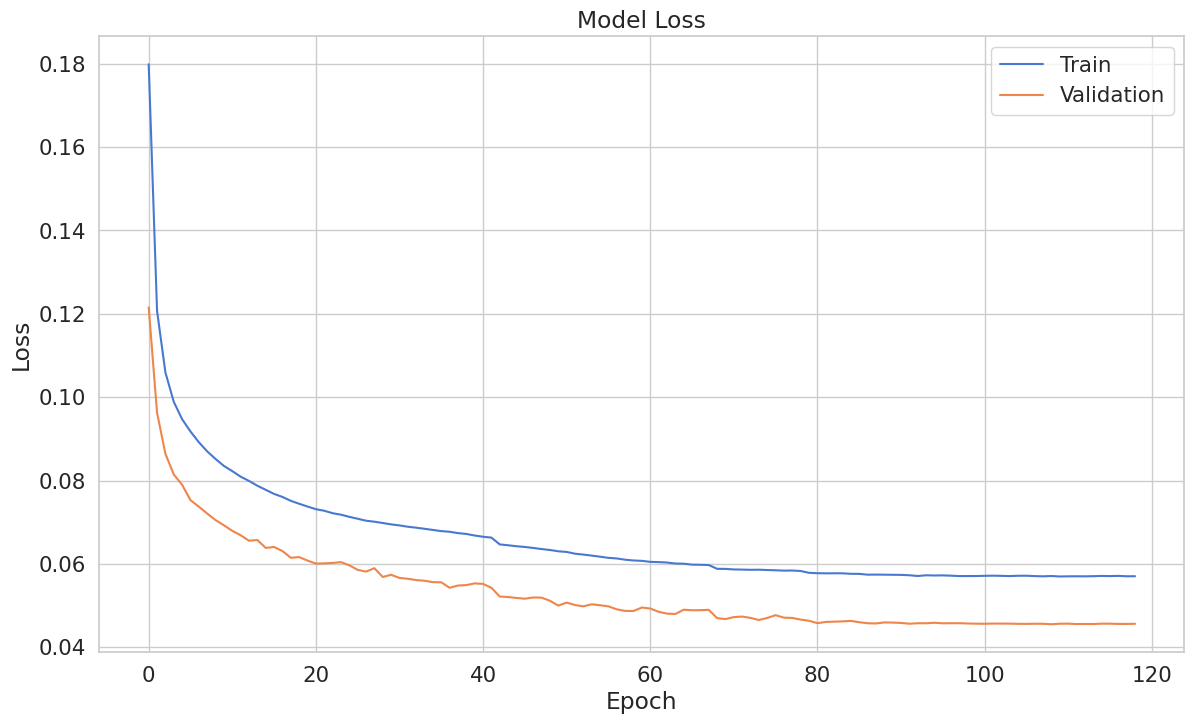

In [45]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [46]:
predictions = autoencoder.predict(X_test)

mse = np.mean(np.power(X_test - predictions, 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test.values
})

error_df.describe()


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.169733,0.001720
std,1.613053,0.041443
min,0.001175,0.000000
25%,0.019658,0.000000
50%,0.045652,0.000000
75%,0.105260,0.000000
max,111.679202,1.000000


In [47]:
normal_errors = error_df[error_df.true_class == 0].reconstruction_error

mu = normal_errors.mean()
sigma = normal_errors.std()

error_df["anomaly_score"] = 1 - norm.cdf(
    error_df.reconstruction_error, mu, sigma
)

y_pred_prob = (error_df.anomaly_score > 0.995).astype(int)

print("=== Probabilistic Autoencoder ===")
print(classification_report(
    error_df.true_class,
    y_pred_prob,
    target_names=LABELS
))


=== Probabilistic Autoencoder ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
threshold_candidates = np.percentile(
    normal_errors, [99.0, 99.2, 99.4, 99.6, 99.8, 99.9]
)

best = (None, -1)

for t in threshold_candidates:
    preds = (error_df.reconstruction_error > t).astype(int)
    f1 = f1_score(error_df.true_class, preds)
    print(f"Threshold {t:.6f} → Fraud F1 = {f1:.4f}")
    if f1 > best[1]:
        best = (t, f1)

threshold = best[0]
print("Selected threshold:", threshold)


Threshold 1.223368 → Fraud F1 = 0.2094
Threshold 1.467460 → Fraud F1 = 0.2417
Threshold 2.000098 → Fraud F1 = 0.2946
Threshold 2.859682 → Fraud F1 = 0.3659
Threshold 5.204678 → Fraud F1 = 0.4354
Threshold 10.228970 → Fraud F1 = 0.4343
Selected threshold: 5.204678376664747


In [49]:
iso = IsolationForest(
    contamination=0.0017,
    random_state=RANDOM_SEED,
    n_estimators=200
)

iso.fit(X_train)

iso_scores = -iso.decision_function(X_test)

rec_err = error_df.reconstruction_error.values
rec_norm = (rec_err - rec_err.min()) / (rec_err.max() - rec_err.min() + 1e-9)
iso_norm = (iso_scores - iso_scores.min()) / (iso_scores.max() - iso_scores.min() + 1e-9)

final_score = 0.6 * rec_norm + 0.4 * iso_norm
final_threshold = np.percentile(final_score[error_df.true_class == 0], 99.5)

y_pred_ensemble = (final_score > final_threshold).astype(int)

print("=== AE + Isolation Forest ===")
print(classification_report(
    error_df.true_class,
    y_pred_ensemble,
    target_names=LABELS
))


=== AE + Isolation Forest ===
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     56864
       Fraud       0.16      0.55      0.25        98

    accuracy                           0.99     56962
   macro avg       0.58      0.77      0.62     56962
weighted avg       1.00      0.99      1.00     56962



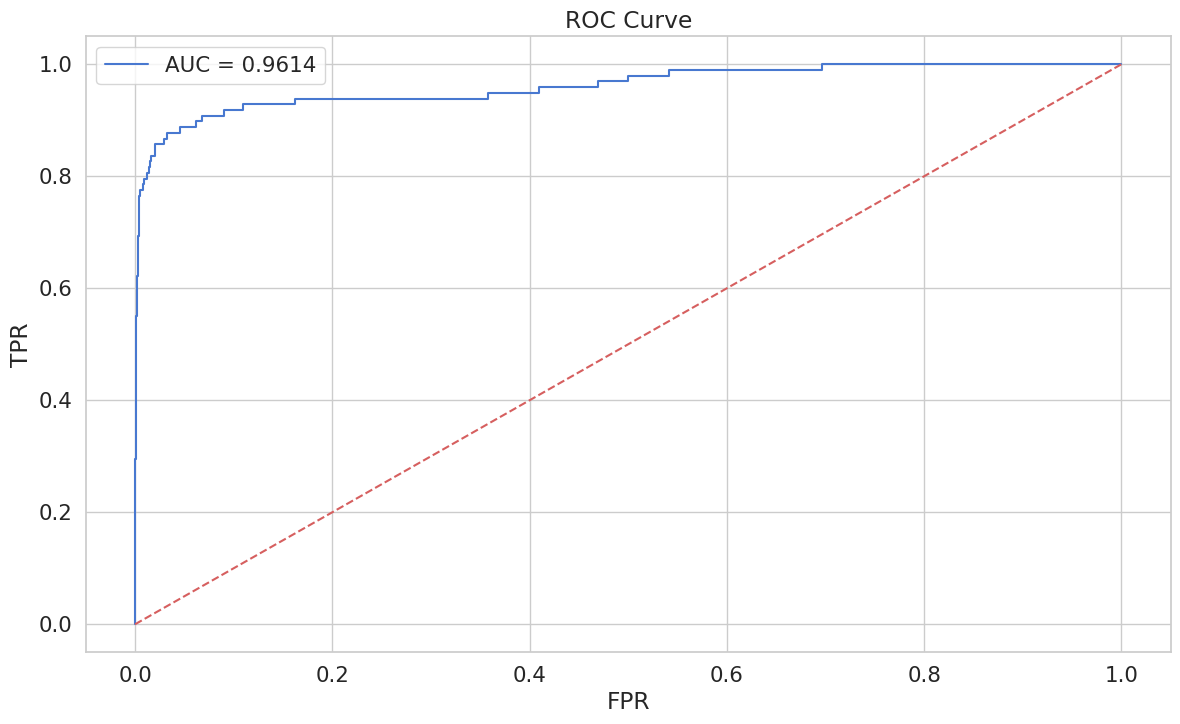

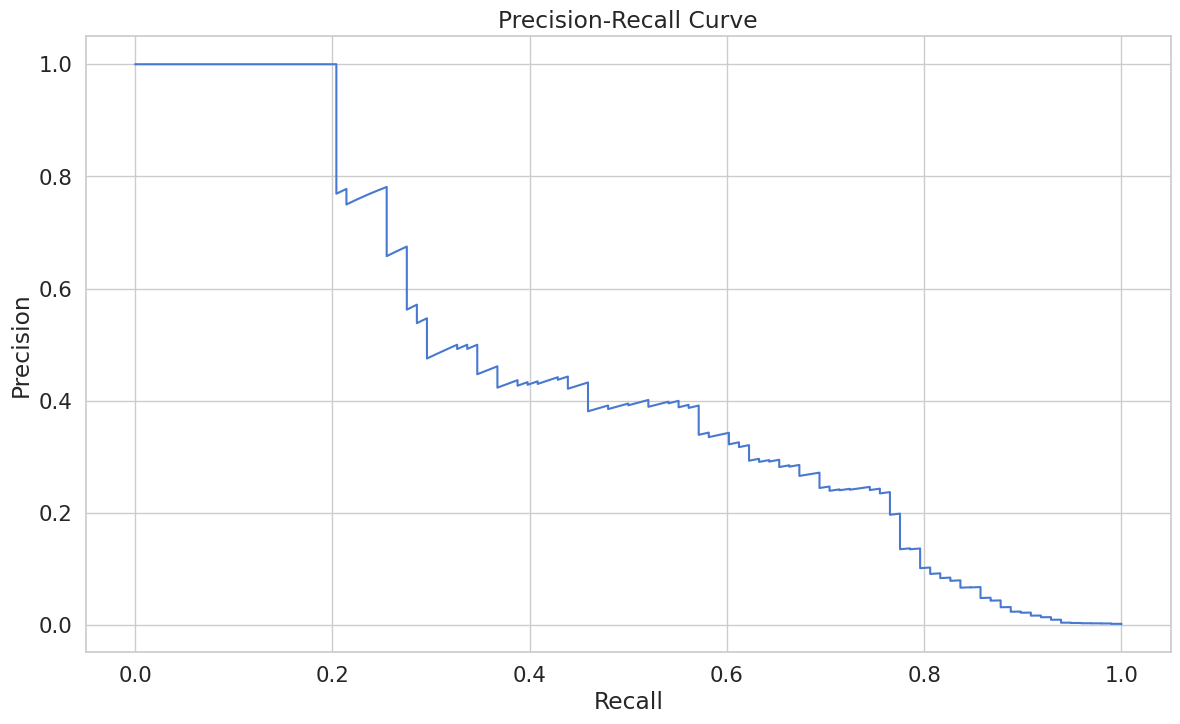

In [50]:
fpr, tpr, _ = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'r--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(
    error_df.true_class,
    error_df.reconstruction_error
)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


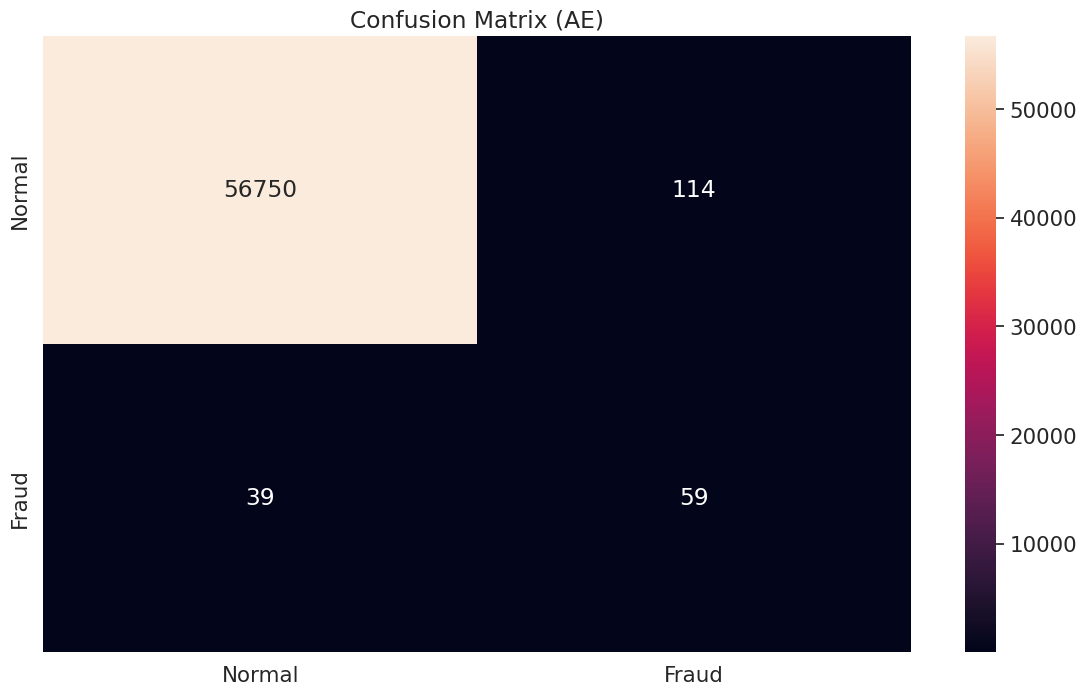

=== Autoencoder ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.34      0.60      0.44        98

    accuracy                           1.00     56962
   macro avg       0.67      0.80      0.72     56962
weighted avg       1.00      1.00      1.00     56962


=== Probabilistic AE ===
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
       Fraud       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962


=== AE + IF Ensemble ===
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     56864
       Fraud       0.16      0.55      0.25        98

    accuracy                           0.99     56962
   macro avg       0.58      0.77      0.62     56962
we

In [53]:
y_pred = (error_df.reconstruction_error > threshold).astype(int)

cm = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=LABELS,
    yticklabels=LABELS
)
plt.title("Confusion Matrix (AE)")
plt.show()

print("=== Autoencoder ===")
print(
    classification_report(
        error_df.true_class,
        y_pred,
        target_names=LABELS,
        zero_division=0
    )
)

print("\n=== Probabilistic AE ===")
print(
    classification_report(
        error_df.true_class,
        y_pred_prob,
        target_names=LABELS,
        zero_division=0
    )
)

print("\n=== AE + IF Ensemble ===")
print(
    classification_report(
        error_df.true_class,
        y_pred_ensemble,
        target_names=LABELS,
        zero_division=0
    )
)


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


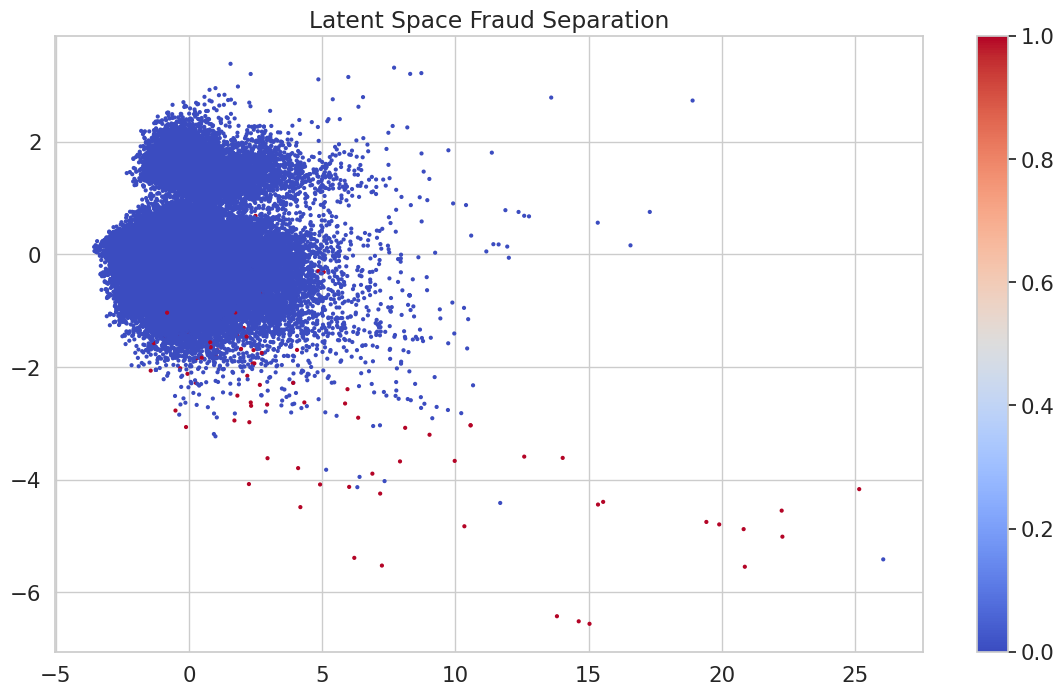

In [52]:
encoder_model = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.get_layer("latent_space").output
)

latent_vectors = encoder_model.predict(X_test)

pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

plt.scatter(
    latent_2d[:,0],
    latent_2d[:,1],
    c=y_test.values,
    cmap='coolwarm',
    s=4
)
plt.title("Latent Space Fraud Separation")
plt.colorbar()
plt.show()
